### Applying model to training data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [11]:
#specify data source 
#datasource = 'L'
#datasource = 'Stanford'

In [12]:
#[zipcode,minutes] = ['08640',15]
#[zipcode,minutes] = ['08641',15]
#[zipcode,minutes] = ['92562',15] #not work for half data because of low number of points.
#[zipcode,minutes] = ['92563',15] #not work for half data because of low number of points.

[datasource,zipcode,minutes] = ['Stanford','94305',1]

In [13]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [14]:
training_data_choice = 0 #0 is full, 1 is first half, 2 is second half (For validation purpose. Check 01_07 for more detail)

In [15]:
if training_data_choice == 0:
    data = pd.read_csv(dataDir +'/training_data.csv')
    dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
    FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")
if training_data_choice == 1:
    data = pd.read_csv(dataDir +'/training_data_1.csv')
    dsummary = pd.read_csv(outputDir+"/fitsummary_1.csv")
    FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef_1.csv")
if training_data_choice == 2:
    data = pd.read_csv(dataDir +'/training_data_2.csv')
    dsummary = pd.read_csv(outputDir+"/fitsummary_2.csv")
    FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef_2.csv")

data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())


In [16]:
def DOY (timestamp): #Stand for "Day of Year"
    if (type(timestamp) is str):
        if len(timestamp) == 19:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d %H:%M:%S").date()
        if len(timestamp) == 10:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
    elif (type(timestamp) is datetime.date):
        Date = timestamp
    elif (type(timestamp) is pd.tslib.Timestamp):
        Date= timestamp.date()
    else:
        print 'not valid time object'
    y = str(Date.year)
    NewYear = datetime.datetime.strptime(y+'-01-01',"%Y-%m-%d").date()
    d = (Date - NewYear).days
    if (int(y)%4==0)&(Date > datetime.datetime.strptime(y+'-02-28',"%Y-%m-%d").date()): #leap year correction
        d = d-1
    return d;

def DBW (timestamp): #DBW ("Day Before Winter Solstice")
    if (type(timestamp) is str):
        if len(timestamp) == 19:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d %H:%M:%S").date()
        if len(timestamp) == 10:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
    elif (type(timestamp) is datetime.date):
        Date = timestamp
    elif (type(timestamp) is pd.tslib.Timestamp):
        Date= timestamp.date()
    else:
        print 'not valid time object'
    y = str(Date.year)
    NewYear = datetime.datetime.strptime(y+'-01-01',"%Y-%m-%d").date()
    d = (Date - NewYear).days
    if (int(y)%4==0)&(Date > datetime.datetime.strptime(y+'-02-28',"%Y-%m-%d").date()): #leap year correction
        d = d-1
    d = d-355
    if d>0:
        d=d-365
    return d;

In [17]:
#This is slow. Need to fix this
data['DBW'] = data.tsLocal.map(lambda x: DBW(x))
data['mpower'] = 0

In [18]:
knots = [-10./12, -8./12, -4./12, 0, 4./12, 8./12, 10./12]
x = data.s
yy = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=True,lower_bound=-1, upper_bound=1) - 1", {"x": x})
#remove last basis (non-zero at endpoint)
#y = np.delete(y,-1,1)
X = yy

for i in range(0,data.shape[0]):
    beta = FullModelCoef[['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10']][FullModelCoef.DBW == data.DBW.iloc[i]]
    #beta = dsummary[['c1_predict','c2_predict','c3_predict','c4_predict','c5_predict','c6_predict','c7_predict','c8_predict',\
    #                 'c9_predict']][dsummary.DateNum == data.DateNum.iloc[i]]
    data.mpower.iloc[i] = np.dot(X[i,:],np.asarray(beta).T)

Write down predicted power in data file.

In [19]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower
0,2013-01-01 07:25:00,0.009829,-298.94417,0.005003,1,6000,-1,-355,0.02947


In [20]:
if training_data_choice == 0:
    data.to_csv(dataDir +'/training_data_fitted.csv',index=False)
if training_data_choice == 1:
    data.to_csv(dataDir +'/training_data_fitted_1.csv',index=False)
if training_data_choice == 2:
    data.to_csv(dataDir +'/training_data_fitted_2.csv',index=False)


In [21]:
dsummary['mE'] = 0
for i in range(0, dsummary.shape[0]): 
    DateOfInterest = dsummary.Date.iloc[i]
    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]

    #calculate total maximum daily energy production unit in kWhr
    if df.shape[0]>0:
        mE = df['mpower'].sum(skipna=False)*minutes/60
        #mE = sum(df.mpower)*15/60
        dsummary.mE.iloc[i] = mE

In [22]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,4.050097,0.944918,0.034118,0.370151,0.451887,0.615727,0.651572,0.672137,0.70027,0.582532,0.431649,0.553558,0.054484,2013-01-01,-355,0.492451,True,False,False,4.040561


In [23]:
if training_data_choice == 0:
    dsummary.to_csv(outputDir +"/fitsummary.csv",index=False)
if training_data_choice == 1:
    dsummary.to_csv(outputDir +"/fitsummary_1.csv",index=False)
if training_data_choice == 2:
    dsummary.to_csv(outputDir +"/fitsummary_2.csv",index=False)


Now consider predicted maximum daily energy production versus real production.

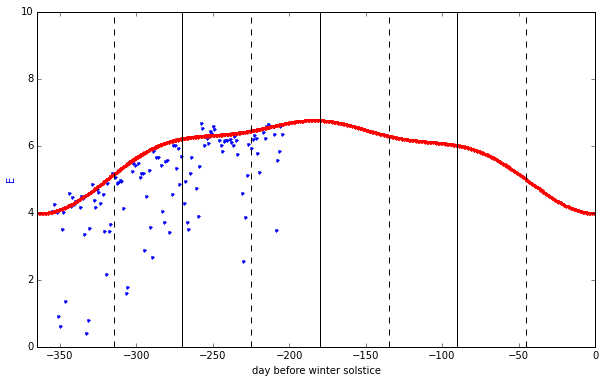

In [24]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

#fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW, dsummary.E, 'b.')
ax1.plot(dsummary.DBW, dsummary.mE, 'r.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
ax1.set_ylim(0,10)
   
for i in [-90,-180,-270]:
    ax1.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    ax1.axvline(x=i, color='black',linestyle='--')
ax1.set_xlim(-365,0)
ax1.set_ylim(0,10)
 
if training_data_choice == 0:
    plt.savefig(outputDir +'/modelpredict.png')
if training_data_choice == 1:
    plt.savefig(outputDir +'/modelpredict_1.png')
if training_data_choice == 2:
    plt.savefig(outputDir +'/modelpredict_2.png')


Here we generate plots of normalized power generation and ideal power envelope on top. We also plots of ratio between actual generation and ideal generation. We add 0.01 on both numerator and denominator in calculation to avoid extreme values. 

(18000.0, 75600.0)

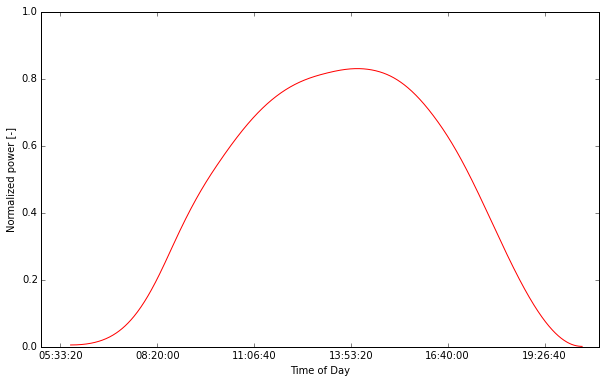

In [25]:
#For thesis, examples of maximum daily power curve

DateOfInterest = "2014-06-24" #21 #24 example for good days
df = data[data.tsLocal.map(lambda x: x.date()) == (datetime.datetime.strptime(DateOfInterest,"%Y-%m-%d")).date()]

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(df.tsLocal.map(lambda x: x.time()),df.power)
ax1.plot(df.tsLocal.map(lambda x: x.time()),df.mpower,color='red')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Normalized power [-]')
ax1.set_ylim([0,1])
ax1.set_xlim([datetime.datetime.strptime(DateOfInterest +" 05:00:00","%Y-%m-%d %H:%M:%S").time(),\
              datetime.datetime.strptime(DateOfInterest +" 21:00:00","%Y-%m-%d %H:%M:%S").time()])
#plt.title('Average normalized power in zipcode ' + zipcode +'\n' +str(DateOfInterest))
#plt.show()

In [26]:
'''
directory = outputDir + '/dailyfit/'
if not os.path.exists(directory):
    os.makedirs(directory)
for i in range(0, dsummary.shape[0]): 
    DateOfInterest = dsummary.Date.iloc[i]
    E = dsummary.E.iloc[i]
    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]

    x = df.s
    if (not math.isnan(E)):
        y = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=False,lower_bound=-1, upper_bound=1) - 1", {"x": x})
        #remove last basis (non-zero at endpoint)
        y = np.delete(y,-1,1)

        X = y
        y = df.power

        #add zero for nan
        y[map(math.isnan,y)] = 0

        beta = scipy.optimize.nnls(X,y)[0]
        dsummary.iloc[i,2:11] = beta
        ypredict = np.dot(X,beta)

        confidence = 0.95
        sigmasquare = np.dot(np.dot(X,beta)-y,np.dot(X,beta)-y)/(len(y)-9-1)
        kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-9-1)
        band = kappa*np.sqrt(np.diagonal(np.mat(X)*(np.linalg.inv(np.mat(X.transpose())*np.mat(X))*np.mat(X.transpose())))*sigmasquare)

        Rsq = 1 - np.std(y-ypredict)*np.std(y-ypredict)/(np.std(y)*np.std(y))

    plt.clf()
    fig = plt.figure(figsize=(8,4))
    ax1  = fig.add_subplot(121)
    if (not math.isnan(E)):
        ax1.plot(x, ypredict,color='black');
        ax1.plot(x, y, marker='+', ls='None')
        ax1.fill_between(x, ypredict- band, ypredict+ band, color='grey', alpha='0.5')
    ax1.plot(x, df.mpower)
    ax1.set_title('Date: '+ DateOfInterest.strftime("%Y-%m-%d") + ', E =' + "{:.3f}".format(float(E))) 
    ax1.set_xlim(-1,1)
    ax1.set_ylim(0,1.1)
    
    ax1  = fig.add_subplot(122)
    if (not math.isnan(E)):
        ax1.plot(x, (df.power+0.01)/(df.mpower+0.01),color='blue');
        ax1.set_title('Date: '+ DateOfInterest.strftime("%Y-%m-%d") + ', relE =' + "{:.3f}".format(float(E)/float(mE)))
    ax1.plot(x, [1.0]*len(x), color='red')
    ax1.set_xlim(-1,1)
    ax1.set_ylim(0,1.1)
    
    filename = DateOfInterest.strftime("%Y-%m-%d") +'.png'
    fig.savefig(directory+filename)
    
    #plt.show()
    '''

'\ndirectory = outputDir + \'/dailyfit/\'\nif not os.path.exists(directory):\n    os.makedirs(directory)\nfor i in range(0, dsummary.shape[0]): \n    DateOfInterest = dsummary.Date.iloc[i]\n    E = dsummary.E.iloc[i]\n    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]\n\n    x = df.s\n    if (not math.isnan(E)):\n        y = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=False,lower_bound=-1, upper_bound=1) - 1", {"x": x})\n        #remove last basis (non-zero at endpoint)\n        y = np.delete(y,-1,1)\n\n        X = y\n        y = df.power\n\n        #add zero for nan\n        y[map(math.isnan,y)] = 0\n\n        beta = scipy.optimize.nnls(X,y)[0]\n        dsummary.iloc[i,2:11] = beta\n        ypredict = np.dot(X,beta)\n\n        confidence = 0.95\n        sigmasquare = np.dot(np.dot(X,beta)-y,np.dot(X,beta)-y)/(len(y)-9-1)\n        kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-9-1)\n        band = kappa*np.sqrt(np.diagonal(np.mat(X)*(np.linalg.

Finally, we have a model to predict maximum power output at any 15 minutes of the year. This information is useful to grid operator to do energy planning. It will be useful in finer power output interval prediction as well.